In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch libraries
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

# Additional libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import albumentations
from albumentations.pytorch import ToTensorV2
import pretrainedmodels

# For progress bars
from tqdm import tqdm

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting
%matplotlib inline


In [9]:
import albumentations
print(f"Albumentations version: {albumentations.__version__}")


Albumentations version: 1.4.15


In [13]:
from albumentations.pytorch import ToTensorV2

# Updated Data Transformations using ImageCompression
data_transforms_resnet = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightnessContrast(p=0.5),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10, p=0.5),
    albumentations.ImageCompression(quality_lower=80, quality_upper=100, compression_type='jpeg', p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

data_transforms_test_resnet = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [14]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, indices, transform=None, labels_dict=None, datatype='train'):
        """
        Args:
            datafolder (string): Directory with all the images.
            indices (list): List of indices for the dataset split.
            transform (callable, optional): Optional transform to be applied on a sample.
            labels_dict (dict, optional): Dictionary mapping image IDs to labels.
            datatype (string): 'train' or 'test'.
        """
        self.datafolder = datafolder
        self.indices = indices
        self.transform = transform
        self.labels_dict = labels_dict
        self.datatype = datatype
        if self.datatype == 'train':
            self.image_files = labels.iloc[indices]['id'].values
        else:
            self.image_files = os.listdir(datafolder)

    def __len__(self):
        return len(self.indices) if self.datatype == 'train' else len(self.image_files)

    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_id = self.image_files[idx]
            img_name = f"{img_id}.tif"
            label = self.labels_dict.get(img_id, 0)
        else:
            img_name = self.image_files[idx]
            label = 0  # Placeholder label for test data

        img_path = os.path.join(self.datafolder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')  # Ensure RGB format
            image = np.array(image)  # Convert PIL Image to NumPy array
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image in case of error
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label


Total training samples: 220025
220025 pictures in train.
57458 pictures in test.


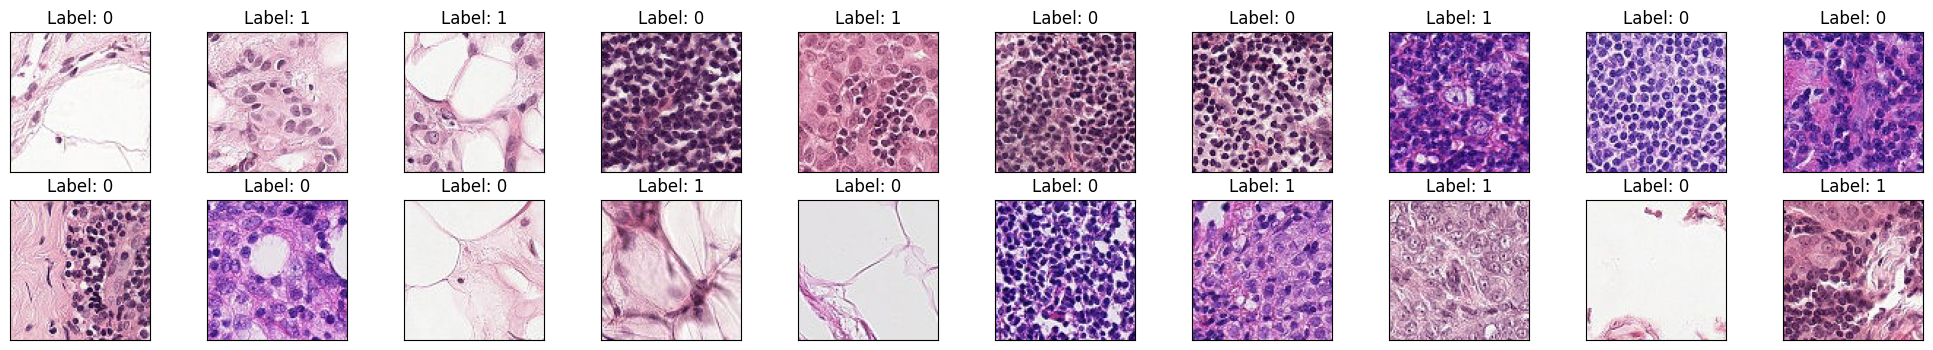

Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Training samples: 198022
Validation samples: 22003


In [15]:
# Load training labels
labels_path = 'train_labels.csv'
labels = pd.read_csv(labels_path)
print(f'Total training samples: {len(labels)}')

# Verify image counts
train_dir = 'train/'
test_dir = 'test/'

print(f'{len(os.listdir(train_dir))} pictures in train.')
print(f'{len(os.listdir(test_dir))} pictures in test.')

# Visualize sample images
num_samples = 20
sample_images = np.random.choice(os.listdir(train_dir), num_samples, replace=False)

fig = plt.figure(figsize=(25, 4))

for idx, img in enumerate(sample_images):
    ax = fig.add_subplot(2, num_samples//2, idx+1, xticks=[], yticks=[])
    img_path = os.path.join(train_dir, img)
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    img_id = img.split('.')[0]
    label = labels.loc[labels['id'] == img_id, 'label'].values[0]
    ax.set_title(f'Label: {label}')

plt.show()

# Check label distribution
print("Label distribution:")
print(labels['label'].value_counts())

# Split data into training and validation sets
test_size = 0.1
random_state = 42

train_indices, val_indices = train_test_split(
    labels.index,
    test_size=test_size,
    stratify=labels['label'],
    random_state=random_state
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Create a dictionary mapping image IDs to labels
img_class_dict = {row['id']: row['label'] for _, row in labels.iterrows()}

# Create training and validation datasets with albumentations transforms
train_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=train_indices,
    transform=data_transforms_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

val_dataset_resnet = CancerDataset(
    datafolder=train_dir,
    indices=val_indices,
    transform=data_transforms_test_resnet,
    labels_dict=img_class_dict,
    datatype='train'
)

# Define batch size and number of workers
batch_size_resnet = 32
num_workers = 4  # Adjust based on your system

# Create DataLoaders
train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=True,
    num_workers=num_workers
)

valid_loader_resnet = DataLoader(
    val_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)

# For test data
test_dataset_resnet = CancerDataset(
    datafolder=test_dir,
    indices=None,  # Not used for test
    transform=data_transforms_test_resnet,
    labels_dict=None,
    datatype='test'
)

test_loader_resnet = DataLoader(
    test_dataset_resnet,
    batch_size=batch_size_resnet,
    shuffle=False,
    num_workers=num_workers
)


In [16]:
# Load the pretrained ResNet50 model
model_resnet = torchvision.models.resnet50(pretrained=True)

# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)  # Binary classification

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ryan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 50.7MB/s]


In [17]:
# Define the loss function
criterion_resnet = nn.BCEWithLogitsLoss()

# Define the optimizer (only the final layer's parameters)
optimizer_resnet = optim.SGD(model_resnet.fc.parameters(), lr=0.005, momentum=0.99)

# Define the learning rate scheduler
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=3, gamma=0.1)


In [18]:
# Number of epochs
n_epochs_resnet = 3

# Early stopping parameters
valid_loss_min_resnet = np.Inf
patience_resnet = 7
p_resnet = 0
stop_resnet = False

for epoch in range(1, n_epochs_resnet + 1):
    print(f'Epoch {epoch}/{n_epochs_resnet}')
    print('-' * 3)
    
    # Initialize variables to track progress
    train_loss = []
    train_auc = []
    model_resnet.train()
    
    # Training phase
    for data, target in tqdm(train_loader_resnet, desc='Training', leave=False):
        data, target = data.to(device), target.float().to(device).unsqueeze(1)
        
        optimizer_resnet.zero_grad()
        output = model_resnet(data)
        loss = criterion_resnet(output, target)
        loss.backward()
        optimizer_resnet.step()
        
        train_loss.append(loss.item())
        
        # Calculate AUC
        preds = torch.sigmoid(output).detach().cpu().numpy()
        targets = target.detach().cpu().numpy()
        train_auc.append(roc_auc_score(targets, preds))
    
    # Validation phase
    model_resnet.eval()
    val_loss = []
    val_auc = []
    
    with torch.no_grad():
        for data, target in tqdm(valid_loader_resnet, desc='Validation', leave=False):
            data, target = data.to(device), target.float().to(device).unsqueeze(1)
            output = model_resnet(data)
            loss = criterion_resnet(output, target)
            val_loss.append(loss.item())
            
            # Calculate AUC
            preds = torch.sigmoid(output).detach().cpu().numpy()
            targets = target.detach().cpu().numpy()
            val_auc.append(roc_auc_score(targets, preds))
    
    # Calculate average losses and AUC
    train_loss_avg = np.mean(train_loss)
    val_loss_avg = np.mean(val_loss)
    train_auc_avg = np.mean(train_auc)
    val_auc_avg = np.mean(val_auc)
    
    print(f'Epoch {epoch}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Train AUC: {train_auc_avg:.4f}, Val AUC: {val_auc_avg:.4f}')
    
    # Check for improvement
    if val_loss_avg < valid_loss_min_resnet:
        print(f'Validation loss decreased ({valid_loss_min_resnet:.6f} --> {val_loss_avg:.6f}). Saving model...')
        torch.save(model_resnet.state_dict(), 'model_resnet.pt')
        valid_loss_min_resnet = val_loss_avg
        p_resnet = 0
    else:
        p_resnet += 1
        print(f'{p_resnet} epochs of increasing val loss')
        if p_resnet > patience_resnet:
            print('Early stopping')
            break
    
    # Step the scheduler
    scheduler_resnet.step()


Epoch 1/3
---


Epoch 1, Train Loss: 1.1752, Val Loss: 0.8780, Train AUC: 0.9054, Val AUC: 0.9394
Validation loss decreased (inf --> 0.877971). Saving model...
Epoch 2/3
---


Epoch 2, Train Loss: 1.2736, Val Loss: 0.8241, Train AUC: 0.9167, Val AUC: 0.9416
Validation loss decreased (0.877971 --> 0.824107). Saving model...
Epoch 3/3
---


Epoch 3, Train Loss: 1.1169, Val Loss: 1.0040, Train AUC: 0.9164, Val AUC: 0.9178
1 epochs of increasing val loss


In [19]:
# Function to evaluate the model
def evaluate_model(model, loader, device, model_type='resnet'):
    model.eval()
    preds = []
    targets_all = []
    
    with torch.no_grad():
        for data, target in tqdm(loader, desc='Evaluating', leave=False):
            data, target = data.to(device), target.float().to(device).unsqueeze(1)
            output = model(data)
            if model_type == 'cnn':
                probs = torch.sigmoid(output)
            else:
                probs = torch.sigmoid(output)
            preds.extend(probs.cpu().numpy())
            targets_all.extend(target.cpu().numpy())
    
    preds = np.array(preds)
    targets_all = np.array(targets_all)
    auc = roc_auc_score(targets_all, preds)
    print(f'AUC: {auc:.4f}')
    return auc

# Evaluate ResNet50
print("Evaluating ResNet50 on Validation Set:")
evaluate_model(model_resnet, valid_loader_resnet, device, model_type='resnet')


Evaluating ResNet50 on Validation Set:


AUC: 0.9176


0.917633691112907

In [23]:
# Load the sample submission file
sample_submission_path = 'input/sample_submission.csv'
sub = pd.read_csv(sample_submission_path)

# Function to generate predictions for the test set
def generate_test_predictions(model, loader, device, model_type='resnet'):
    model.eval()
    preds = []
    image_ids = []
    
    with torch.no_grad():
        for data, _ in tqdm(loader, desc='Generating Predictions', leave=False):
            data = data.to(device)
            output = model(data)
            if model_type == 'cnn':
                probs = torch.sigmoid(output)
            else:
                probs = torch.sigmoid(output)
            preds.extend(probs.cpu().numpy())
    
    # Assuming test_dataset.image_files contains image IDs without extensions
    image_ids = [img_id.split('.')[0] for img_id in test_dataset_resnet.image_files]
    
    # Create a DataFrame with predictions
    test_preds = pd.DataFrame({'id': image_ids, 'label': preds})
    
    # Ensure 'id' matches the submission format
    test_preds['id'] = test_preds['id'].astype(str)
    
    return test_preds

# Generate predictions using ResNet50
test_preds = generate_test_predictions(model_resnet, test_loader_resnet, device, model_type='resnet')

# Merge with the sample submission
sub = sub.drop('label', axis=1)
sub = sub.merge(test_preds, on='id', how='left')

# Handle any missing predictions
sub['label'] = sub['label'].fillna(0.0)

# Save the submission file
sub.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")


Submission file saved as 'submission.csv'.
